In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import numpy as np
import pandas as pd
import sys
sys.path.append(r'/home/jmwang/WorkSpace/GENiPPI/')
from gPPMol.nets import EncoderCNN, DecoderRNN, GNN_Model

/home/jmwang/anaconda3/envs/GENiPPI/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gPPMol.utils import *
from tqdm import tqdm
import argparse
import multiprocessing
from gPPMol.ppi_processing.collate_fn import collate_fn
from gPPMol.ppi_processing.Prepare_Input import Prepare_Input
from gPPMol.ppi_processing.Single_Dataset import Single_Dataset
from torch.utils.data import DataLoader

from gPPMol.models_3d.wgan_clipping import WGAN_CP
from gPPMol.models_3d.wgan_gradient_penalty import WGAN_GP

In [3]:
batch_size = 8
savedir = "model"
os.makedirs(savedir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(device)
is_cuda = True if device == "cuda" else False

structure_path="./interface.pdb"
input_file=Prepare_Input(structure_path)
list_npz = [input_file]
dataset = Single_Dataset(list_npz)
dataloader = DataLoader(dataset, 1, shuffle=False,
                            num_workers=1,
                            drop_last=False, collate_fn=collate_fn)
for batch_idx, sample in enumerate(dataloader):
    H, A1, A2, V, Atom_count = sample
    break

smiles = np.load("./gPPMol/example.npy") #(305584, 242)   105
y = np.load("./gPPMol/example_y.npy") #(305584,)

from gPPMol.comgen import decode_smiles
from gPPMol.gene import queue_datagen

multiproc = multiprocessing.Pool(1)
my_gen = queue_datagen(smiles, y, batch_size=batch_size, mp_pool=multiproc)
test_loader  = my_gen

from gPPMol.comgen import decode_smiles

cpu
Extracting 1639/1639 atoms for receptor, 1599/1599 atoms for ligand
After filtering the interface region, 54/201 residue in receptor, 40/182 residue in ligand
After filtering the interface region, 408 receptor, 392 ligand
./interface.rinterface ./interface.linterface
[[ 38.15   52.213  -3.876]
 [ 39.356  51.642  -4.511]
 [ 40.527  51.747  -3.51 ]
 ...
 [ 53.013  74.879 -19.824]
 [ 53.707  75.566 -20.61 ]
 [ 52.493  75.422 -18.869]] (800, 3) [75.068 82.97   7.071] [ 33.114  36.699 -29.936] [20.977  23.1355 18.5035] [41.954 46.271 37.007] HEADER    CORNERS OF BOX
REMARK    CENTER (X Y Z)  20.977   23.136  18.504
REMARK    DIMENSIONS (X Y Z)   41.954  46.271  37.007 
ATOM      1  DUA BOX     1      33.114  36.699 -29.936
ATOM      2  DUB BOX     1      75.068  36.699 -29.936
ATOM      3  DUC BOX     1      75.068  36.699   7.071
ATOM      4  DUD BOX     1      33.114  36.699   7.071
ATOM      5  DUE BOX     1      33.114   82.97 -29.936
ATOM      6  DUF BOX     1      75.068   82.97 -

In [4]:
# Define the networks
params={}
params['n_graph_layer'] =4  #图卷积的层数
params['d_graph_layer'] =140  #图卷积每一层有多少个节点
params['n_FC_layer'] =4    #全连接层数
params['d_FC_layer'] =128    #全连接层每一层多少个节点
params['dropout_rate'] =0.3
params['initial_mu'] =0.0
params['initial_dev'] =1.0
params['N_atom_features'] = 28     #每个原子有28个特征值  不可修改
params['final_dimension'] = 4* 4* 4    #将 interface feature map to a 128 size of vector  can be changed
gnn_interface_model = GNN_Model(params)

encoder = EncoderCNN(9)
decoder = DecoderRNN(512, 1024, 37, 1)

gnn_interface_model.to(device)
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(37, 512)
  (lstm): LSTM(512, 1024, batch_first=True)
  (linear): Linear(in_features=1024, out_features=37, bias=True)
)

In [5]:
model_name = 'WGAN-CP'
channels = 9
generator_iters = 50000
batch_size = 8

if model_name == 'WGAN-CP':
    model = WGAN_CP(channels,is_cuda,generator_iters,gnn_interface_model,encoder,decoder,device,batch_size=8)
elif model_name == 'WGAN-GP':
    model = WGAN_GP(channels,is_cuda,generator_iters,gnn_interface_model,encoder,decoder,device,batch_size=8)        
else:
    print("Model type non-existing. Try again.")
    exit(-1)

WGAN_CP init model.


In [6]:
load_D = './discriminator.pkl'
load_G = './generator.pkl'

In [7]:
# Start model training
captions1,captions2 = model.evaluate( test_loader,load_D, load_G,H, A1, A2, V, Atom_count)
aa = decode_smiles(captions1,captions2)

from rdkit import Chem

def filter_unique_canonical(in_mols):
    """
    :param in_mols - list of SMILES strings
    :return: list of uinique and valid SMILES strings in canonical form.
    """
    xresults = [Chem.MolFromSmiles(x) for x in in_mols]  # Convert to RDKit Molecule
    xresults = [Chem.MolToSmiles(x) for x in xresults if x is not None]  # Filter out invalids
    return [x for x in set(xresults)]  # Check for duplicates and filter out invalids

aa=filter_unique_canonical(aa)

print(aa,len(aa))

/home/jmwang/WorkSpace/GENiPPI/code/gPPMol/nets.py:303: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  count_receptor = len(c_valid[batch_idx].nonzero())


['CC1=NN(c2ccc(Br)cc2)C(=O)C1=Cc1cccs1', 'CC1OC(OC2C(OC(=O)C34CCC(C)(C)CC3C3=CCC5C6(C)CC(O)C(OC7OC(CO)C(O)C(O)C7O)C(CO)(CO)C6CCC5(C)C3(C)CC4O)OCC(O)C2O)C(O)C(O)C1OC1OCC(O)C(OC2OCC(O)(CO)C2O)C1O', 'Cc1cc(C(C)(C)C)c(O)cc1OCc1cccc(F)c1', 'CC1=C(O)C(=O)C=C2C1=CC=C1C2(C)CCC2(C)C3CC(C)(C(=O)O)CCC3(C)CCC12C', 'Cc1cc(C)n(-c2nc(NN)nc(Nc3ccc(Cl)c(C(F)(F)F)c3)n2)n1', 'C=C1C(=O)C2=CC1CCC(=O)C1(C)C(OC(C)=O)CCC(C)(C)C1CC2O', 'CC1=CC(C)CC(C)CC(C)C(Cc2cnco2)OC(=O)C(C)=CC(C)CC(C)C(Cc2cnco2)OC1=O', 'C=CC=CC(C)=CCC=C1CC(OC2C(=O)OC(C)=CC(C)(C)C2O)C(CO)C(OC(C)=O)C(C)C1=C', 'CS(=O)CCCCN=C=S', 'CS(=O)CCNCCCCCCSc1ccc(Cl)cc1'] 10


2019.03.4


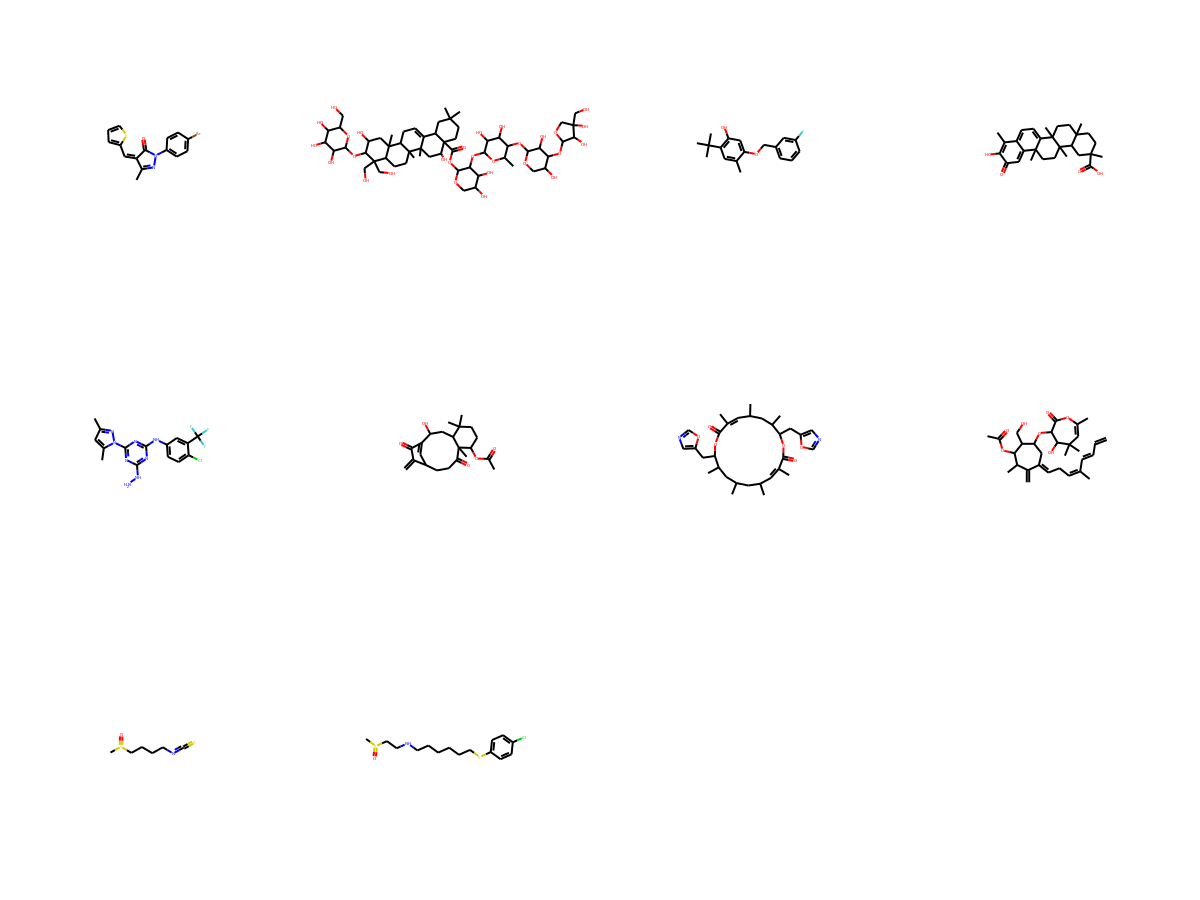

In [8]:
%matplotlib inline
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
print(rdBase.rdkitVersion)
genmols = [Chem.MolFromSmiles(x) for x in aa]
Chem.Draw.MolsToGridImage(genmols, molsPerRow=4, subImgSize=(300, 300)) 